<a href="https://colab.research.google.com/github/ritwiks9635/Transformer_Model/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image classification with Vision Transformer**

In [ ]:
!pip install keras --upgrade

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_class = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print("x_train shape is ::", x_train.shape)
print("x_test shape is ::", x_test.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape is :: (50000, 32, 32, 3)
x_test shape is :: (10000, 32, 32, 3)


#**Configuration**

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor = 0.002),
        layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ], name = "data_augmentation")

data_augmentation.layers[0].adapt(x_train)

#**MultiLayer Perception**

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement the patch

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size


    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channel = input_shape[3]
        patch_h = height // self.patch_size
        patch_w = width // self.patch_size
        patches = ops.image.extract_patches(images, size = self.patch_size)
        patches = tf.reshape(patches, (batch_size, patch_h * patch_w, self.patch_size * self.patch_size * channel))
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size" : self.patch_size})
        return config

#plot the patch

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


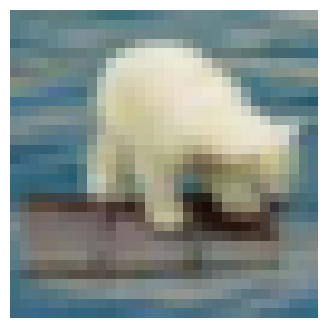

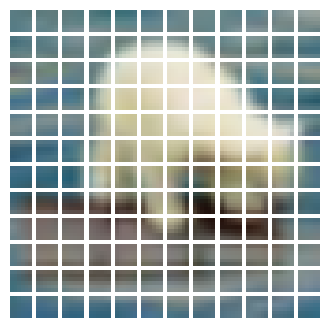

In [8]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

#**Implement the patch encoding layer**
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.pos = layers.Embedding(input_dim = num_patches, output_dim = projection_dim)

    def call(self, patch):
        positions = np.arange(start = 0, stop = self.num_patches, step = 1)
        positions = np.expand_dims(positions, axis = 0)
        projected_patch = self.projection(patch)
        encoded = projected_patch + self.pos(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches" : self.num_patches})
        return config

#**Build the ViT model**
The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

In [19]:
def create_vit_classifier():
    inputs = keras.Input(shape = input_shape)
    augment = data_augmentation(inputs)
    patches = Patches(patch_size)(augment)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads = num_heads, key_dim = projection_dim, dropout = 0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        x4 = mlp(x = x3, hidden_units = transformer_units, dropout_rate = 0.1)
        encoded_patches = layers.Add()([x4, x2])
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    outputs = layers.Dense(num_class)(features)

    model = keras.Model(inputs, outputs)
    return model

#**Compile, train, and evaluate**

In [22]:
def run_experimental(model):
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate,  weight_decay = weight_decay)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = "accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name = "top_5_accuracy")
        ]

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    checkpoint = keras.callbacks.ModelCheckpoint(
        "my_model.weights.h5",
        monitor = "val_accuracy",
        save_best_only = True,
        save_weights_only = True)

    history = model.fit(
        x_train, y_train,
        batch_size = batch_size,
        validation_split = 0.1,
        epochs = num_epochs,
        callbacks = [checkpoint])

    model.load_weights("my_model.weights.h5")
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [23]:
model = create_vit_classifier()
history = run_experimental(model)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 406ms/step - accuracy: 0.0284 - loss: 4.9026 - top_5_accuracy: 0.1102 - val_accuracy: 0.0962 - val_loss: 3.9788 - val_top_5_accuracy: 0.2920
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 399ms/step - accuracy: 0.0842 - loss: 4.0221 - top_5_accuracy: 0.2663 - val_accuracy: 0.1560 - val_loss: 3.5750 - val_top_5_accuracy: 0.4136
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 421ms/step - accuracy: 0.1244 - loss: 3.7388 - top_5_accuracy: 0.3527 - val_accuracy: 0.1916 - val_loss: 3.3749 - val_top_5_accuracy: 0.4654
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 79s 402ms/step - accuracy: 0.1575 - loss: 3.5293 - top_5_accuracy: 0.4149 - val_accuracy: 0.2198 - val_loss: 3.2142 - val_top_5_accuracy: 0.5098
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 421ms/step - accuracy: 0.1867 - loss: 3.3589 - top_5_accuracy: 0.4606 - val_accuracy: 0.2502 - val_loss: 3.0788 - val_top_5_accuracy: 0.5444
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 410ms/step - accuracy: 0.2124 

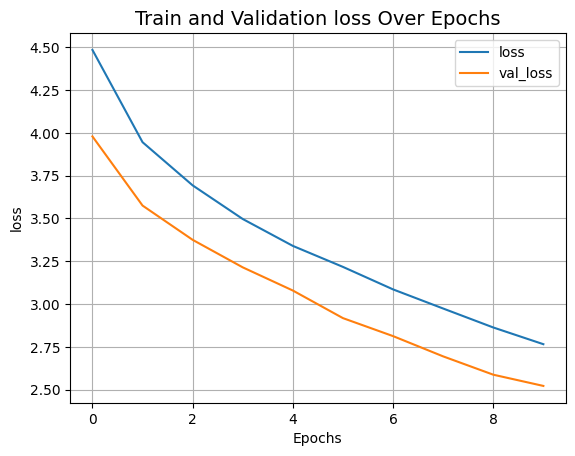

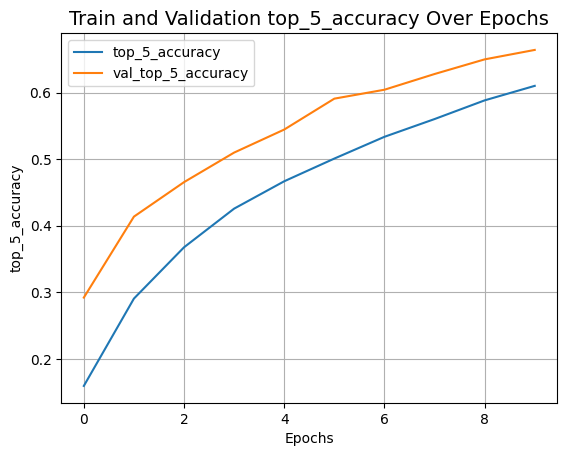

In [25]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top_5_accuracy")